In [1]:
%load_ext autoreload
%autoreload 2

In [81]:
import numpy as np
import sys
sys.path.insert(0, '../YOLO_intro')
from Object_Detection import ObjectDectection
import cv2
from matplotlib import pyplot as plt

In [82]:
from ObjectDetectionGenerator import ObjectDetectionGenerator, annotate_image_from_nn_out, get_train_val_generators, get_train_val_annotations_split

In [83]:
PASCAL_VOC_FOLDER = '/home/usuario/repos/Object_Localization/dataset/'
PASCAL_VOC_ANNOTATIONS_FOLDER_TRAIN = PASCAL_VOC_FOLDER + 'ILSVRC/Annotations/CLS-LOC/train'
PASCAL_VOC_ANNOTATIONS_FOLDER_VAL = PASCAL_VOC_FOLDER + 'ILSVRC/Annotations/CLS-LOC/val'
PASCAL_VOC_IMAGES_FOLDER_TRAIN = PASCAL_VOC_FOLDER + 'ILSVRC/Data/CLS-LOC/train'
PASCAL_VOC_IMAGES_FOLDER_VAL = PASCAL_VOC_FOLDER + 'ILSVRC/Data/CLS-LOC'
classes = ['n02165456', 'n02226429', 'n01644373', 'n02279972', 'n01632458', 'n02256656', 'n01774384', 'n01770393']
(IMAGE_H,IMAGE_W) = (320,448)
batch_size = 32
GRID_H = IMAGE_H // 32
GRID_W = IMAGE_W // 32
NUMBER_OF_BBOXES = 1

In [84]:
annotations_train, _ = get_train_val_annotations_split(PASCAL_VOC_ANNOTATIONS_FOLDER, 
                                                                     classes=classes, 
                                                                     MAX_NUMBER_OF_BBOXES_PER_CELL=NUMBER_OF_BBOXES, 
                                                                     split_ratio = 0.)

(1/8) Class n02165456 has 675 images in train and 0 images in val
(2/8) Class n02226429 has 711 images in train and 0 images in val
(3/8) Class n01644373 has 676 images in train and 0 images in val
(4/8) Class n02279972 has 644 images in train and 0 images in val
(5/8) Class n01632458 has 687 images in train and 0 images in val
(6/8) Class n02256656 has 643 images in train and 0 images in val
(7/8) Class n01774384 has 655 images in train and 0 images in val
(8/8) Class n01770393 has 603 images in train and 0 images in val
found 5294 images in 8 classes


In [85]:
_, annotations_val = get_train_val_annotations_split(PASCAL_VOC_ANNOTATIONS_FOLDER_VAL, \
                                                                     classes=classes, \
                                                                     MAX_NUMBER_OF_BBOXES_PER_CELL=NUMBER_OF_BBOXES, \
                                                                     split_ratio = 1., CLASSES_BY_DIR=False)

file 50000/50000
{'n02165456': 43, 'n02226429': 49, 'n01644373': 45, 'n02279972': 49, 'n01632458': 44, 'n02256656': 41, 'n01774384': 48, 'n01770393': 49}
found 368 images in 8 classes


In [86]:
train_generator = ObjectDetectionGenerator(annotations_train, 
                                           PASCAL_VOC_IMAGES_FOLDER_TRAIN, 
                                           batch_size, 
                                           (IMAGE_H,IMAGE_W), 
                                           classes, NUMBER_OF_BBOXES, GRID_H, GRID_W)

val_generator = ObjectDetectionGenerator(annotations_val, 
                                         PASCAL_VOC_IMAGES_FOLDER_VAL, 
                                         batch_size, 
                                         (IMAGE_H,IMAGE_W), 
                                         classes, NUMBER_OF_BBOXES, GRID_H, GRID_W)

In [88]:
train_generator.samples, val_generator.samples

(5294, 368)

In [89]:
class_idx_to_name = {
    'n02165456': 'V. san antonio',
    'n02226429': 'grillo',
    'n01644373': 'sapo',
    'n02279972': 'mariposa',
    'n01632458': 'salamandra',
    'n02256656': 'chicharra',
    'n01774384': 'viuda negra',
    'n01770393': 'escorpion'
}

1.0


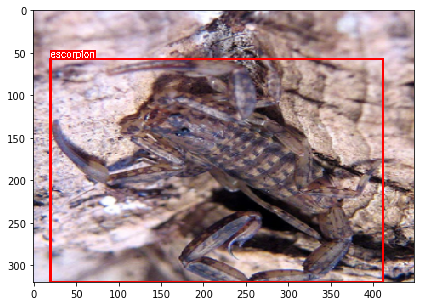

In [91]:
images, nn_annotations = next(val_generator)
for i, image in enumerate(images):
    img_with_annot = annotate_image_from_nn_out(image, nn_annotations[i], classes, class_idx_to_name)
    print(np.max(img_with_annot))
    plt.figure(figsize=(20,5))
    plt.imshow(img_with_annot)
    plt.show()
    break

In [92]:
object_detection = ObjectDectection(len(classes), IMAGE_H, IMAGE_W, NUMBER_OF_BBOXES = 1)

In [93]:
model = object_detection.model
model.output

<tf.Tensor 'reshape_3/Reshape:0' shape=(?, 10, 14, 1, 13) dtype=float32>

In [94]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop, SGD
filename = 'runtime'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_classes_acc', save_best_only=True)
model.compile(loss=[
        object_detection.losses.YOLO_loss(k_classes = 1, k_bboxes = 1, k_no_object=0.5, k_object = 1)
        # "mse"
        ], 
              optimizer=Adam(lr=0.001),
              metrics=[object_detection.metrics.classes_accuracy(), 
                       object_detection.metrics.IOU(), 
                       object_detection.metrics.object_accuracy(),
                       object_detection.metrics.no_object_accuracy(),
                       # object_detection.losses.focal_loss(),
                       object_detection.losses.bounding_box_mse(),
                       object_detection.losses.object_bin_cross_entropy_loss(),
                       object_detection.losses.no_object_bin_cross_entropy_loss()
                      ]
             )

In [95]:
model.load_weights('weights_yolo_loss_bigger_dataset.hdf5')

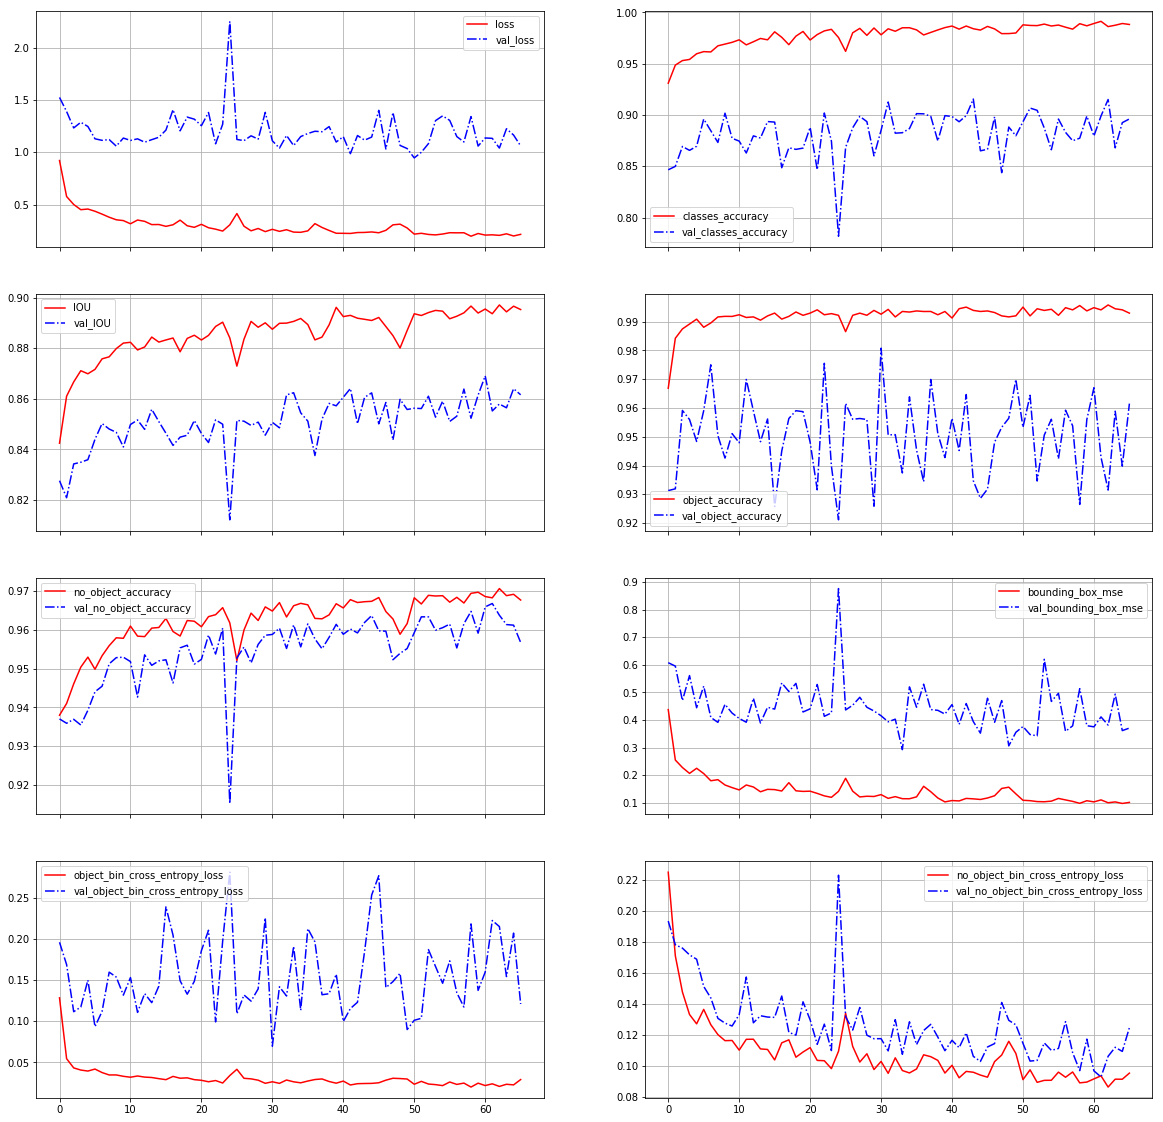

Epoch 67/2000
 46/166 [=======>......................] - ETA: 46s - loss: 0.1733 - classes_accuracy: 0.9945 - IOU: 0.9021 - object_accuracy: 0.9932 - no_object_accuracy: 0.9676 - bounding_box_mse: 0.0866 - object_bin_cross_entropy_loss: 0.0206 - no_object_bin_cross_entropy_loss: 0.0951

In [ ]:
from Object_Detection import PlotLosses
plot_losses = PlotLosses(1)
model.fit_generator(train_generator,epochs=2000,
        validation_data=val_generator,
        callbacks = [plot_losses])

In [82]:
#model.load_weights('weights_yolo_focal_loss.hdf5')
metrics_values = model.evaluate_generator(val_generator)
for i, met in enumerate(metrics_values):
    print(model.metrics_names[i], ':', met)

loss : 1.0265828263288164
classes_accuracy : 0.9378531074568826
IOU : 0.848476277569593
object_accuracy : 0.9030131834599482
no_object_accuracy : 0.9825372372643423
focal_loss : 0.035597664144472435
bounding_box_mse : 0.2929604719699888
object_bin_cross_entropy_loss : 0.3354214570728848
no_object_bin_cross_entropy_loss : 0.056706255017700845


In [83]:
def save_data(model, filename_suffix):
    model.save_weights('weights'+filename_suffix+'.hdf5')
    np.save('history' + filename_suffix, model.history.history)

In [85]:
filename_suffix = '_yolo_loss_bigger_dataset_with_val'
save_data(model, filename_suffix)